In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sys
import sklearn
import io
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from scikeras.wrappers import KerasClassifier
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline


In [ ]:
# Load the dataset (replace 'path_to_dataset' with the actual path)
data = pd.read_csv('UNSW_NB15_tset.csv')

In [ ]:
data['attack_cat'].value_counts()

# Preprocessing

In [ ]:
# Handle missing values (fill with 0 in this example)
data.fillna(0, inplace=True)

In [ ]:
# Extract features and labels
X = data.drop('attack_cat', axis=1)
y_attack_cat = data['attack_cat']
y_label = data['label']

In [ ]:

# Step 2: Identify numeric and categorical features is a crucial step in our preprocessing 
#using the select_dtypes to filter columns in the data that have data types float64 and int64 
#the columns.tolist : return our columns filtered and convert it to a list that contain the names of numeric columns 
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
#for categorical features we filter columns by object meaning that columns may contain strings or other data non numeric 
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

In [ ]:
# Feature Scaling for numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[numeric_features])

In [ ]:
# One-Hot Encoding for categorical features
data = pd.get_dummies(data, columns=categorical_features)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Reshape data for LSTM input
X_lstm = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Creating RNN model

In [ ]:
# Define RNN model
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=False))  # Removed return_sequences=True
    model.add(Dense(1, activation='sigmoid'))
    #compiling the model contain three parameter
  #*loss: define the function that the model will use during training, 'binary_crossentropy' used in binary classification that predicte probabilities 
  #*optimizer: for the optimization of algorithme we use 'adam' is an optimization algorithm that adjusts the learning rate in training to handle all different types of data
  #*metrics: specifying the metrics that will be computed during training and testing so that it will compute the accuracy(proportion of correctly predicted) metric 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
input_shape = (X_lstm.shape[1], X_lstm.shape[2])
model = create_rnn_model(input_shape)

In [ ]:
# Get unique attack categories
attack_categories = np.unique(y_attack_cat)

In [ ]:
# Initialize dictionary to store metrics for each attack category
metrics_by_category = {
    "accuracy": {},
    "precision": {},
    "recall": {},
    "f1_score": {},
    "roc_auc": {}
}
# Lists to store evaluation metrics for each attack category
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []

Epoch 1/5
1370/1370 [==============================] - 94s 62ms/step - loss: 0.6238 - accuracy: 0.8443
Epoch 2/5
1370/1370 [==============================] - 91s 66ms/step - loss: 3.2460 - accuracy: 0.7257
Epoch 3/5
1370/1370 [==============================] - 88s 64ms/step - loss: 0.6185 - accuracy: 0.8196
Epoch 4/5
1370/1370 [==============================] - 84s 61ms/step - loss: 0.3433 - accuracy: 0.8925
Epoch 5/5
2740/2740 [==============================] - 46s 15ms/step
Epoch 1/5
1370/1370 [==============================] - 93s 62ms/step - loss: 0.4887 - accuracy: 0.7480
Epoch 2/5
1370/1370 [==============================] - 84s 61ms/step - loss: 0.1203 - accuracy: 0.9494
Epoch 3/5
1370/1370 [==============================] - 86s 63ms/step - loss: 0.0528 - accuracy: 0.9877
Epoch 4/5
1370/1370 [==============================] - 85s 62ms/step - loss: 0.0131 - accuracy: 0.9983
Epoch 5/5
2740/2740 [==============================] - 87s 29ms/step


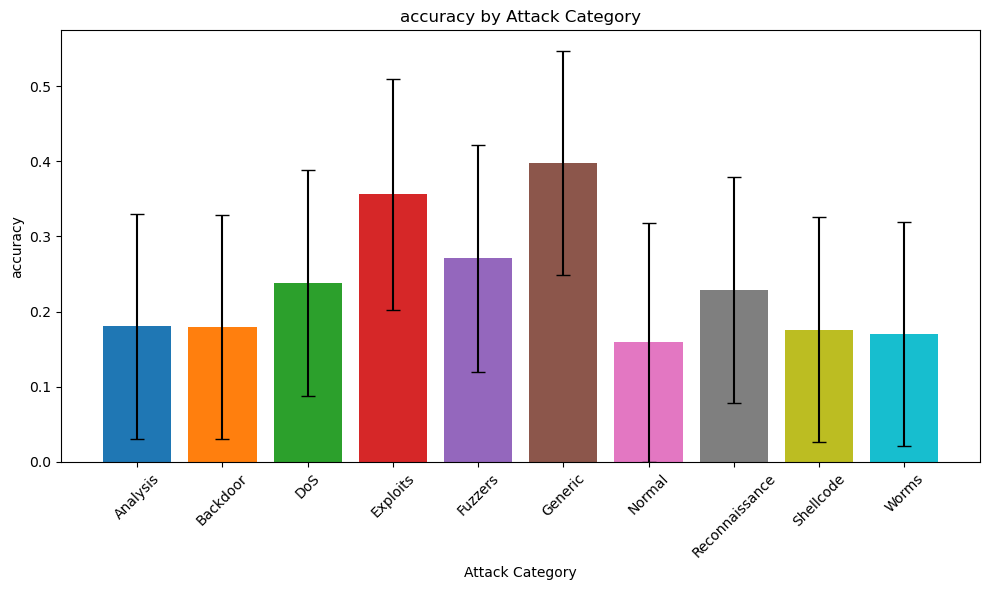

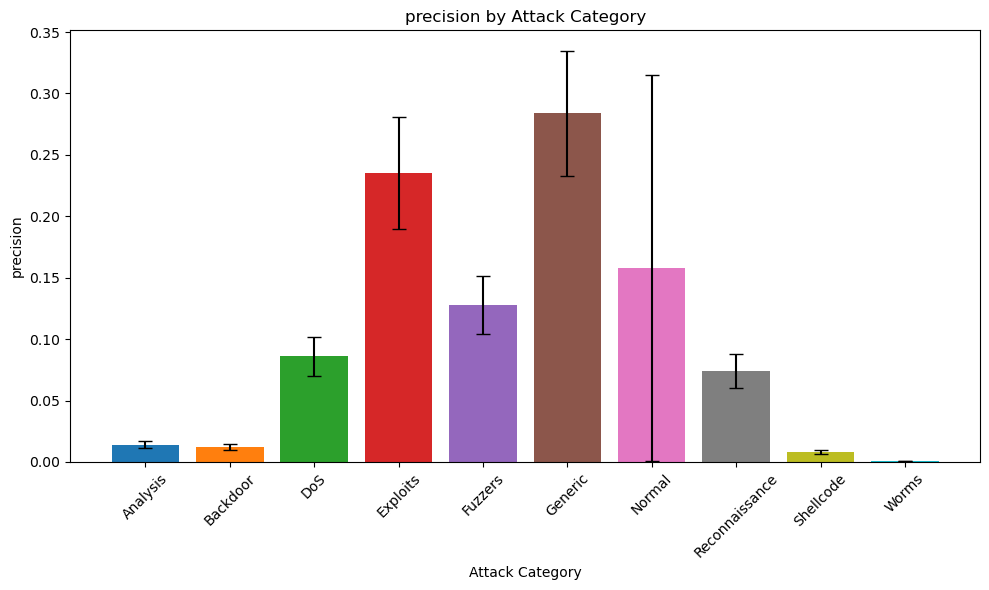

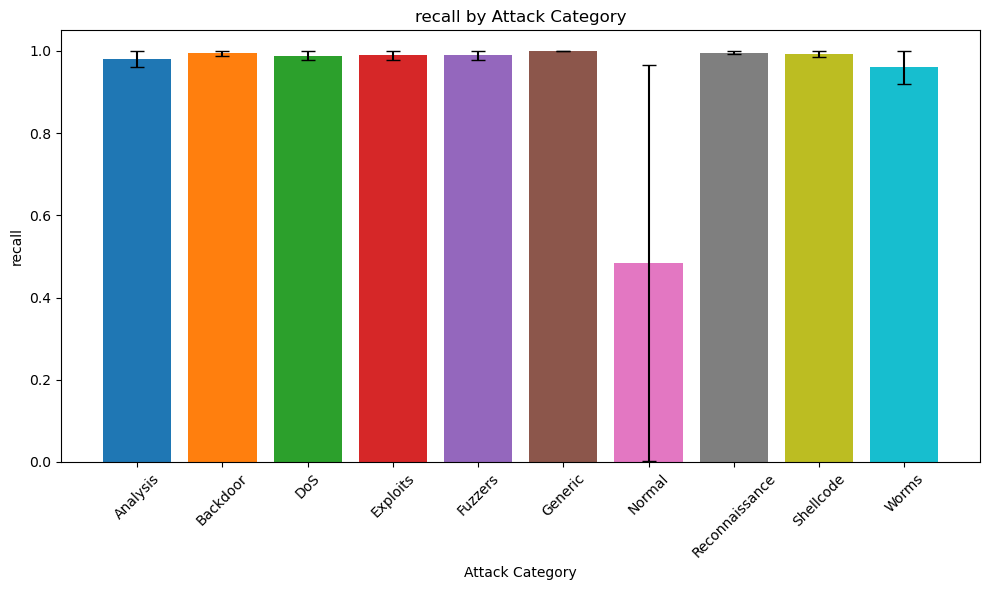

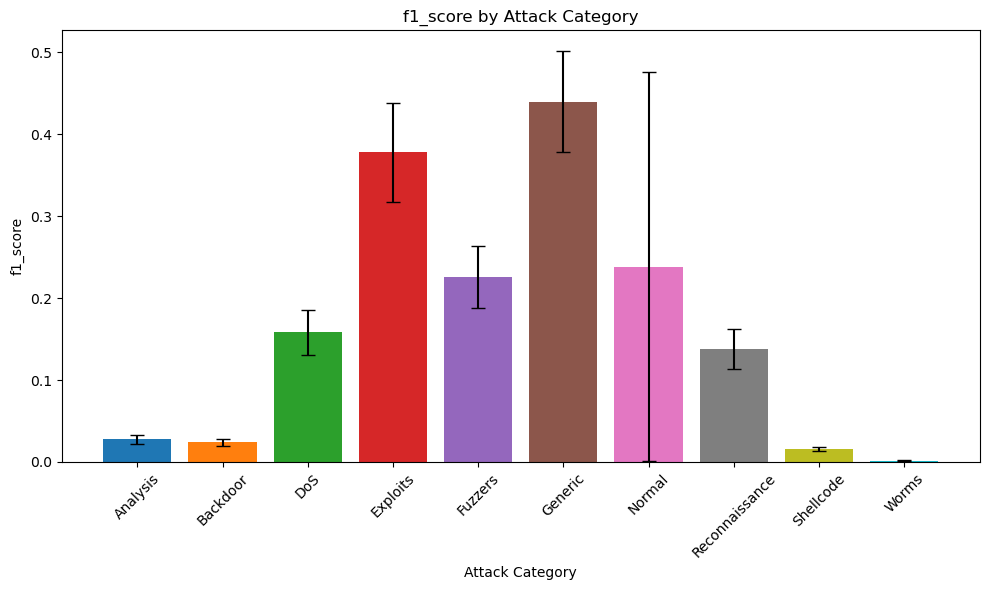

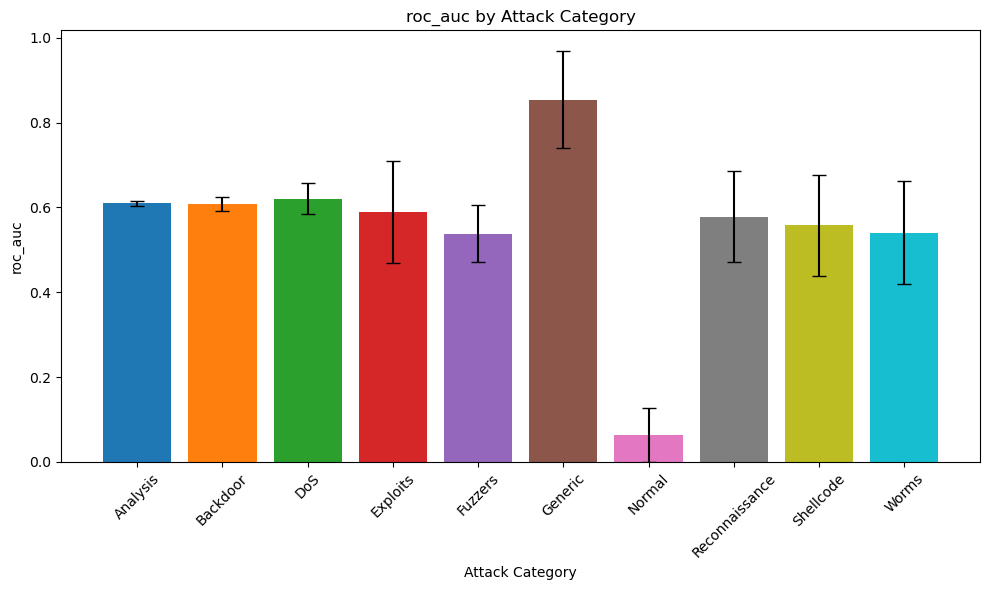

In [11]:
# K-Fold Cross-Validation
num_folds = 2 # Number of folds
#shuffle is 'true' so that the data is randomly shuffled before the split 
kf = KFold(n_splits=num_folds, shuffle=True)

# Perform K-Fold Cross-Validation
#for the kf.split it return iterators that yield for each fold spliting the data into validation set and training set
for train_idx, test_idx in kf.split(X_lstm):
    X_train, X_test = X_lstm[train_idx], X_lstm[test_idx]
    y_train_attack_cat, y_test_attack_cat = y_attack_cat[train_idx], y_attack_cat[test_idx]
    y_train_label, y_test_label = y_label[train_idx], y_label[test_idx]
    
    # Train the model
    #The epochs: parameter specifies the number of times that is passed forward and backward through the model in training
    #batch_size: for not updating the weights model each time we specify a batch_size lead us to a faster training if the 
     #the value is big 
    model.fit(X_train, y_train_label, epochs=5, batch_size=64, verbose=1)
    
    for attack_category in attack_categories:
        # Create binary labels for the current attack category
        y_train_binary = (y_train_attack_cat == attack_category).astype(int)
        y_test_binary = (y_test_attack_cat == attack_category).astype(int)
        
        # predict for the current attack category
        y_pred = model.predict(X_test)
        y_pred_binary = (y_pred > 0.5).astype(int)
        
       # Calculate evaluation metrics
        accuracy = accuracy_score(y_test_binary, y_pred_binary)
        precision = precision_score(y_test_binary, y_pred_binary)
        recall = recall_score(y_test_binary, y_pred_binary)
        f1 = f1_score(y_test_binary, y_pred_binary)
        roc_auc = roc_auc_score(y_test_binary, y_pred)
        
        # Store metrics in dictionaries
        metrics_by_category["accuracy"].setdefault(attack_category, []).append(accuracy)
        metrics_by_category["precision"].setdefault(attack_category, []).append(precision)
        metrics_by_category["recall"].setdefault(attack_category, []).append(recall)
        metrics_by_category["f1_score"].setdefault(attack_category, []).append(f1)
        metrics_by_category["roc_auc"].setdefault(attack_category, []).append(roc_auc)

# Plot metrics for each attack category
for metric_name, metric_values in metrics_by_category.items():
    plt.figure(figsize=(10, 6))
    for attack_category, values in metric_values.items():
        plt.bar(attack_category, np.mean(values), yerr=np.std(values), capsize=5)
    plt.title(f"{metric_name} by Attack Category")
    plt.xlabel("Attack Category")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [12]:
# Display values and plot metrics for each attack category
for metric_name, metric_values in metrics_by_category.items():
    print(f"{metric_name.upper()} BY ATTACK CATEGORY:")
    for attack_category, values in metric_values.items():
        print(f"Attack Category: {attack_category}")
        print(f"Mean {metric_name}: {np.mean(values)}")
        print(f"Standard Deviation: {np.std(values)}")
        print("--------------------------")

ACCURACY BY ATTACK CATEGORY:
Attack Category: Analysis
Mean accuracy: 0.1804606441845833
Standard Deviation: 0.1498119690240399
--------------------------
Attack Category: Backdoor
Mean accuracy: 0.17935422614856333
Standard Deviation: 0.1493671152453
--------------------------
Attack Category: DoS
Mean accuracy: 0.2378459717401866
Standard Deviation: 0.1505308960595168
--------------------------
Attack Category: Exploits
Mean accuracy: 0.3557933068142369
Standard Deviation: 0.15421011510888388
--------------------------
Attack Category: Fuzzers
Mean accuracy: 0.27093578350451686
Standard Deviation: 0.15121546549742218
--------------------------
Attack Category: Generic
Mean accuracy: 0.3974321428356895
Standard Deviation: 0.14935695263596557
--------------------------
Attack Category: Normal
Mean accuracy: 0.15939136433107726
Standard Deviation: 0.158786824579737
--------------------------
Attack Category: Reconnaissance
Mean accuracy: 0.2288748788128255
Standard Deviation: 0.15012591

In [13]:
# Create and display a table for each metric
for metric_name, metric_values in metrics_by_category.items():
    table_data = []
    header = ["Attack Category", "Mean Value", "Standard Deviation"]
    
    for attack_category, values in metric_values.items():
        mean_value = np.mean(values)
        std_value = np.std(values)
        table_data.append([attack_category, mean_value, std_value])
    
    table_df = pd.DataFrame(table_data, columns=header)
    print(f"{metric_name.upper()} BY ATTACK CATEGORY:")
    print(table_df)
    print("\n")

ACCURACY BY ATTACK CATEGORY:
  Attack Category  Mean Value  Standard Deviation
0        Analysis    0.180461            0.149812
1        Backdoor    0.179354            0.149367
2             DoS    0.237846            0.150531
3        Exploits    0.355793            0.154210
4         Fuzzers    0.270936            0.151215
5         Generic    0.397432            0.149357
6          Normal    0.159391            0.158787
7  Reconnaissance    0.228875            0.150126
8       Shellcode    0.175881            0.149418
9           Worms    0.170206            0.149413


PRECISION BY ATTACK CATEGORY:
  Attack Category  Mean Value  Standard Deviation
0        Analysis    0.013960            0.002819
1        Backdoor    0.012307            0.002179
2             DoS    0.086114            0.015952
3        Exploits    0.235013            0.045632
4         Fuzzers    0.127799            0.023936
5         Generic    0.283724            0.050944
6          Normal    0.157922          

In [15]:
from tabulate import tabulate  # Import tabulate
# Display tables for each metric using tabulate
for metric_name, metric_values in metrics_by_category.items():
    table_data = []
    
    for attack_category, values in metric_values.items():
        mean_value = np.mean(values)
        std_value = np.std(values)
        table_data.append([attack_category, mean_value, std_value])
    
    print(f"{metric_name.upper()} BY ATTACK CATEGORY:")
    table = tabulate(table_data, headers=["Attack Category", "Mean Value", "Standard Deviation"], tablefmt="fancy_grid")
    print(table)
    print("\n")

ACCURACY BY ATTACK CATEGORY:
╒═══════════════════╤══════════════╤══════════════════════╕
│ Attack Category   │   Mean Value │   Standard Deviation │
╞═══════════════════╪══════════════╪══════════════════════╡
│ Analysis          │     0.180461 │             0.149812 │
├───────────────────┼──────────────┼──────────────────────┤
│ Backdoor          │     0.179354 │             0.149367 │
├───────────────────┼──────────────┼──────────────────────┤
│ DoS               │     0.237846 │             0.150531 │
├───────────────────┼──────────────┼──────────────────────┤
│ Exploits          │     0.355793 │             0.15421  │
├───────────────────┼──────────────┼──────────────────────┤
│ Fuzzers           │     0.270936 │             0.151215 │
├───────────────────┼──────────────┼──────────────────────┤
│ Generic           │     0.397432 │             0.149357 │
├───────────────────┼──────────────┼──────────────────────┤
│ Normal            │     0.159391 │             0.158787 │
├──────────